## Analyzing New York Red Bulls 2024 Performance in MLS Games

## Context
The New York Red Bulls, aka RBNY, are one of the teams in Major League Soccer (MLS). They are one of the ten charter clubs of MLS, having competed in the league since its founding in 1996.

 vs NYCFC game?

1. Performance of team across years: dot plot of goals/games across years. the question, are they improving overall as a team.
2. Gather info across the years to see what characteristics for attackers, defenders, midfielders allows for higher goal scoring. 3 Heat maps. 
3. on an individual basis, how can these characteristics help the players improve. do they have values that are outliers which they should focus on.
4. tableau dashboard.


In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator



## Team performance across years


In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file with all sheets
file_path = "RBNY_Scores.xlsx"  # Update this with the actual file path
excel_data = pd.ExcelFile(file_path)

# Initialize a dictionary to store performance metrics for each year
performance_metrics = {}

# Iterate through each sheet (year)
for sheet_name in excel_data.sheet_names:
    # Load the sheet into a DataFrame
    df = excel_data.parse(sheet_name)
    
    # Ensure the columns are named properly
    df.columns = df.columns.str.strip()  # Remove any leading/trailing spaces
    
    # Calculate the total GF, total GA, and number of games
    total_gf = df["GF"].sum()  
    total_ga = df["GA"].sum()
    num_games = len(df)
    
    # Calculate the performance metric
    performance = (total_gf - total_ga) / num_games if num_games > 0 else 0
    performance_metrics[int(sheet_name)] = performance  # Store year as an integer

# Convert the dictionary into a DataFrame for easier plotting
performance_df = pd.DataFrame(list(performance_metrics.items()), columns=["Year", "Performance"])
performance_df = performance_df.sort_values("Year")  # Sort by year

# Plot the performance metrics
plt.figure(figsize=(10, 6))
plt.plot(performance_df["Year"], performance_df["Performance"], 'o-', color='blue', label="Performance")
plt.axhline(0, color='grey', linestyle='--', linewidth=1)  # Add a line at y=0 for reference
plt.title("Team Performance Across Years", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Performance Metric ((GF - GA) / Games)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


KeyError: 'GF'

In [13]:
# Sample classification of players (this should be updated with accurate roles)
player_roles = {
    "Morgan": "Midfielder", "Forsberg": "Midfielder", "Manoel": "Attacker", "Harper": "Attacker", "Vanzeir": "Attacker", "Carmona": "Midfielder",
    "Gjengaar": "Attacker", "Hall": "Attacker", "Tolkin": "Defender", "Amaya": "Midfielder", "Burke": "Attacker", "Carballo": "Midfielder",
    "Duncan": "Defender", "Ngoma": "Attacker", "Reyes": "Defender", "Estrela": "Midfielder", "Marcucci": "Goalkeeper", "Mitchell": "Attacker",
    "O'Connor": "Defender", "Odle": "Goalkeeper", "Ofori": "Defender", "Rosborough": "Midfielder", "Sofo": "Attacker", "Sserwadda": "Midfielder",
    "Valencia": "Defender", "Alexandre": "Defender", "Coronel": "Goalkeeper", "Donkor": "Midfielder", "Edelman": "Midfielder", "Eile": "Defender",
    "Kasule": "Midfielder", "Meara": "Goalkeeper", "Meyer": "Goalkeeper", "Mina": "Defender", "Mullings": "Attacker", "Nealis": "Defender",
    "Nealis": "Defender", "Shapiro-Thompson": "Midfielder", "Stokes": "Goalkeeper", "Stroud": "Midfielder",
    "Martínez": "Attacker", "Rodríguez": "Midfielder", "Wolf": "Attacker", "Bakrar": "Attacker", "Ojeda": "Attacker", "Perea": "Midfielder",
    "Fernández": "Attacker", "Parks": "Midfielder", "Gray": "Defender", "Ilenic": "Defender", "Jones": "Attacker", "Magno": "Attacker",
    "Thiago": "Defender", "Moralez": "Midfielder", "O'Toole": "Attacker", "Sands": "Midfielder", "Arroyave": "Midfielder", "Baiera": "Defender",
    "Carrizo": "Midfielder", "Elias": "Midfielder", "Hope-Gund": "Defender",  "Jasson": "Midfielder", "Acevedo": "Midfielder", "Andrade": "Attacker",
    "Barraza": "Goalkeeper", "Benalcazar": "Defender", "Denis": "Attacker", "Freese": "Goalkeeper", "Haak": "Midfielder", "McFarlane": "Defender",
    "Mijatovic": "Attacker", "Mizell": "Goalkeeper", "Morales": "Midfielder", "Owusu": "Defender", "Pellegrini": "Midfielder", "Rando": "Goalkeeper",
    "Risa": "Defender", "Romero": "Goalkeeper", "Segal": "Attacker", "Shore": "Midfielder", "Tanasijević": "Defender", "Turnbull": "Defender",
    "Yañez": "Attacker", "Martins": "Midfielder", "Tanasijevic": "Defender"
}

In [3]:
# Load player stats data for 2024 mls games
rbny_avg_season = pd.read_excel('rbny_stats_2024/files/avg_mls_stats.xlsx')
nyc_avg_season = pd.read_excel('nycfc_stats_2024/files/avg_mls_stats.xlsx')

# Load player stats data for 2024 mls games
rbny_season = pd.read_excel('rbny_stats_2024/files/season_stats_per_player.xlsx')
nyc_season = pd.read_excel('nycfc_stats_2024/files/season_stats_per_player.xlsx')

# Load the game-specific data for RBNY and NYC
rbny_game = pd.read_excel('rbny_stats_2024/files/game_stats_sept_18.xlsx')
nyc_game = pd.read_excel('nycfc_stats_2024/files/game_stats_sept_18.xlsx')


# Add 'Team' column to distinguish the team of each player
rbny_avg_season['Team'] = 'RBNY'
rbny_season['Team'] = 'RBNY'
rbny_game['Team'] = 'RBNY'

nyc_avg_season['Team'] = 'NYCFC'
nyc_season['Team'] = 'NYCFC'
nyc_game['Team'] = 'NYCFC'

# Concatenate the two datasets into one
combined_season_avg = pd.concat([rbny_avg_season, nyc_avg_season], ignore_index=True)
combined_season = pd.concat([rbny_season, nyc_season], ignore_index=True)
combined_game = pd.concat([rbny_game, nyc_game], ignore_index=True)

# Add role column based on the player names and player_roles
combined_season_avg['Role'] = combined_season_avg['Last Name'].map(player_roles)
combined_season['Role'] = combined_season['Last Name'].map(player_roles)
combined_game['Role'] = combined_game['Last Name'].map(player_roles)

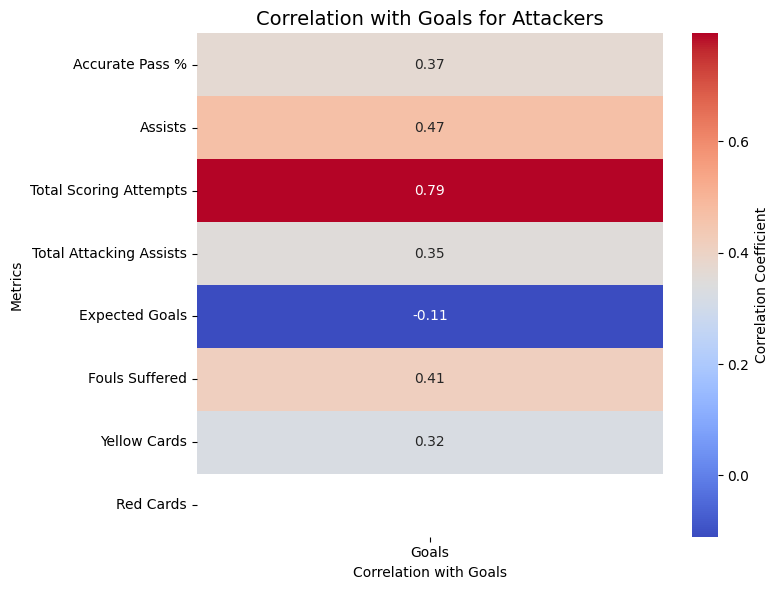

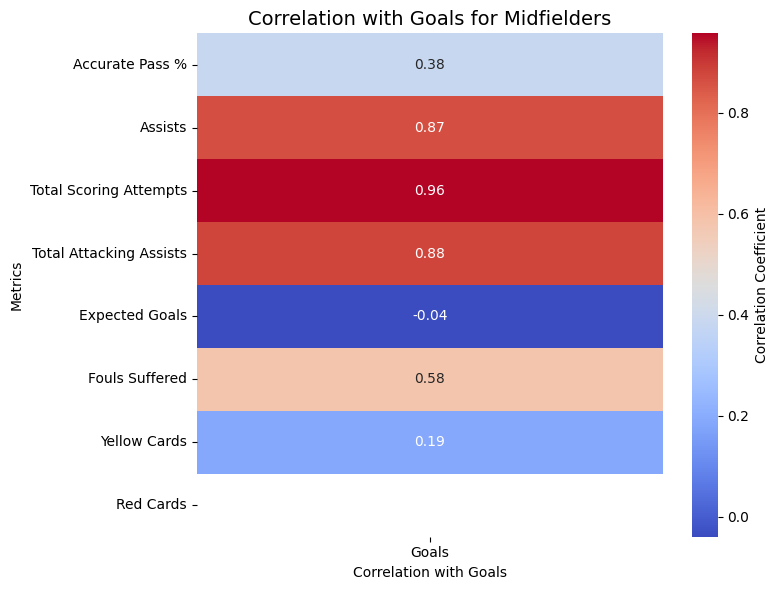

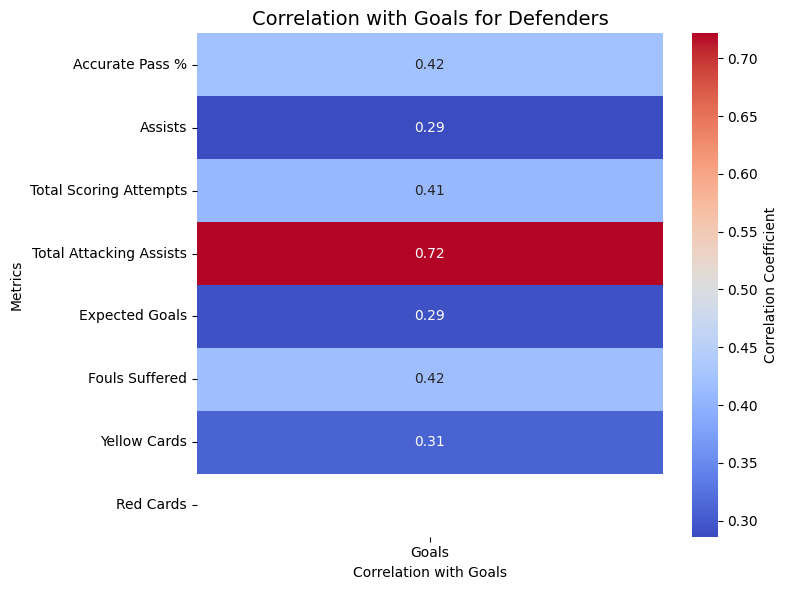

In [4]:
# Filter to keep only numeric columns
columns_to_plot = [col for col in combined_season_avg.columns.intersection(combined_game.columns) if pd.api.types.is_numeric_dtype(combined_season_avg[col])]

# Filter data by Role
roles = ['Attacker', 'Midfielder', 'Defender']

# Plot correlation heatmap for each role
for role in roles:
    # Filter data for the current role
    role_data = combined_season_avg[combined_season_avg['Role'] == role]
    
    # Compute correlation matrix
    corr_matrix = role_data[columns_to_plot].corr()
    
    # Focus on 'Goals' correlation
    corr_with_goals = corr_matrix[['Goals']].drop(index='Goals')
    
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        corr_with_goals, 
        annot=True, 
        fmt='.2f', 
        cmap='coolwarm', 
        cbar=True, 
        yticklabels=corr_with_goals.index, 
        cbar_kws={'label': 'Correlation Coefficient'}
    )
    
    # Adjust layout and titles
    plt.title(f"Correlation with Goals for {role}s", fontsize=14)
    plt.ylabel("Metrics")
    plt.xlabel("Correlation with Goals")
    plt.tight_layout()
    plt.show()

In [5]:
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt

# Define role-specific columns
role_columns = {
    'Attacker': ['Total Scoring Attempts'],
    'Midfielder': ['Assists', 'Total Scoring Attempts']
}

# Initialize a list to store results
results = []

# Function to check normality and plot distributions
def check_normality(data, column):
    stat, p_value = shapiro(data[column].dropna())
    return p_value > 0.05, stat, p_value

# Perform statistics for each role and column
for role, columns in role_columns.items():
    role_data = combined_season[(combined_season['Role'] == role) & (combined_season['Team'] == 'RBNY')]
    game_role_data = combined_game[(combined_game['Role'] == role) & (combined_game['Team'] == 'RBNY')]
    print(role_data)
    for column in columns:
        # Check normality for season and game data
        season_normal, season_stat, season_p = check_normality(role_data, column)
        game_normal, game_stat, game_p = check_normality(game_role_data, column)
        
        # Perform statistical test between season and game data
        if season_normal and game_normal:
            # Use t-test
            test_name = "T-Test"
            stat, p_value = ttest_ind(role_data[column].dropna(), game_role_data[column].dropna())
        else:
            # Use Mann-Whitney U test
            test_name = "Mann-Whitney U Test"
            stat, p_value = mannwhitneyu(role_data[column].dropna(), game_role_data[column].dropna())
        
        # Determine conclusion
        conclusion = "Significant Difference" if p_value < 0.05 else "No Significant Difference"
        
        # Append results to the list
        results.append({
            'Role': role,
            'Metric': column,
            'Season Normal (P-Value)': season_p,
            'Game Normal (P-Value)': game_p,
            'Test Used': test_name,
            'Test Stat': stat,
            'P-Value': p_value,
            'Conclusion': conclusion
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Export results to an Excel file
output_file = "Player_Role_Analysis.xlsx"
with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
    results_df.to_excel(writer, index=False, sheet_name='Analysis Results')
    print(f"Results saved to {output_file}")


    Last Name First Name       Date    OPP Result  Goals  Assists  \
48     Manoel      Elias  Sat 10/19  vsCLB   L3-2    0.0      0.0   
49     Manoel      Elias   Sat 10/5   @ATL   L2-1    0.0      0.0   
50     Manoel      Elias   Wed 10/2   @TOR   W4-1    1.0      0.0   
51     Manoel      Elias   Sat 9/28  vsNYC   L5-1    0.0      0.0   
52     Manoel      Elias   Sat 9/21  vsATL   D2-2    1.0      0.0   
..        ...        ...        ...    ...    ...    ...      ...   
622  Mitchell      Roald   Sat 3/23  vsMIA   W4-0    0.0      0.0   
623  Mitchell      Roald   Sat 3/16   @CLB   L3-0    0.0      0.0   
624  Mitchell      Roald    Sat 3/9  vsDAL   W2-1    0.0      0.0   
625  Mitchell      Roald    Sat 3/2   @HOU   W2-1    0.0      0.0   
626  Mitchell      Roald   Sun 2/25   @NSH   D0-0    0.0      0.0   

     On Target Scoring Attempts  Total Scoring Attempts  Fouls Committed  ...  \
48                          1.0                     0.0              0.0  ...   
49       

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [6]:
role_data = combined_season[(combined_season['Role'] == role) & (combined_season['Team'] == 'RBNY')]
game_role_data = combined_game[(combined_game['Role'] == role) & (combined_game['Team'] == 'RBNY')]

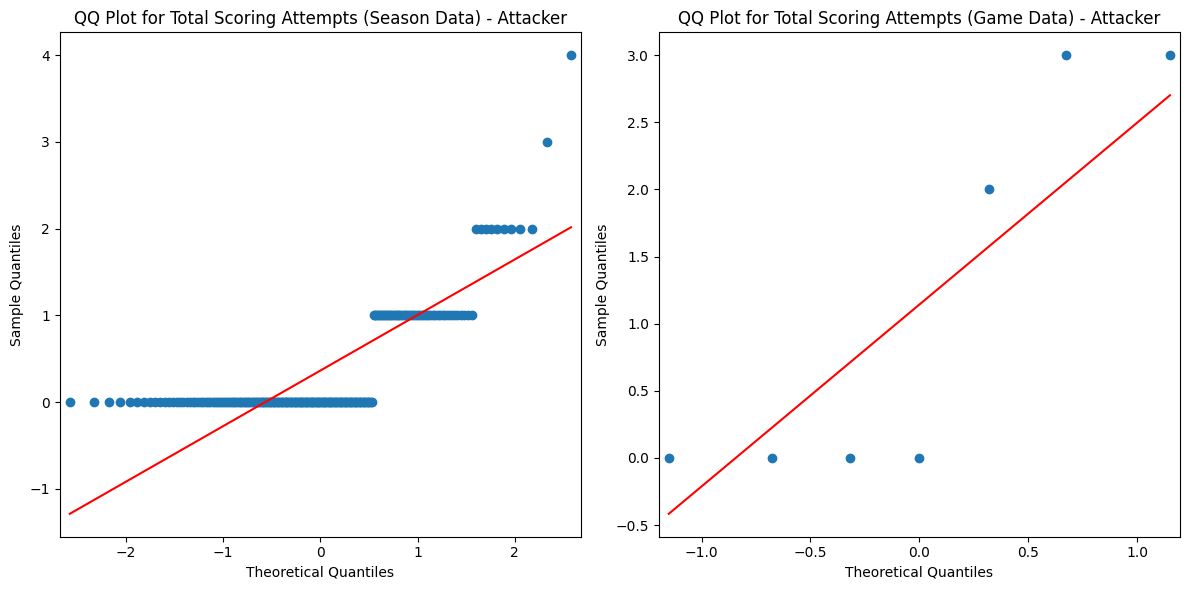

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


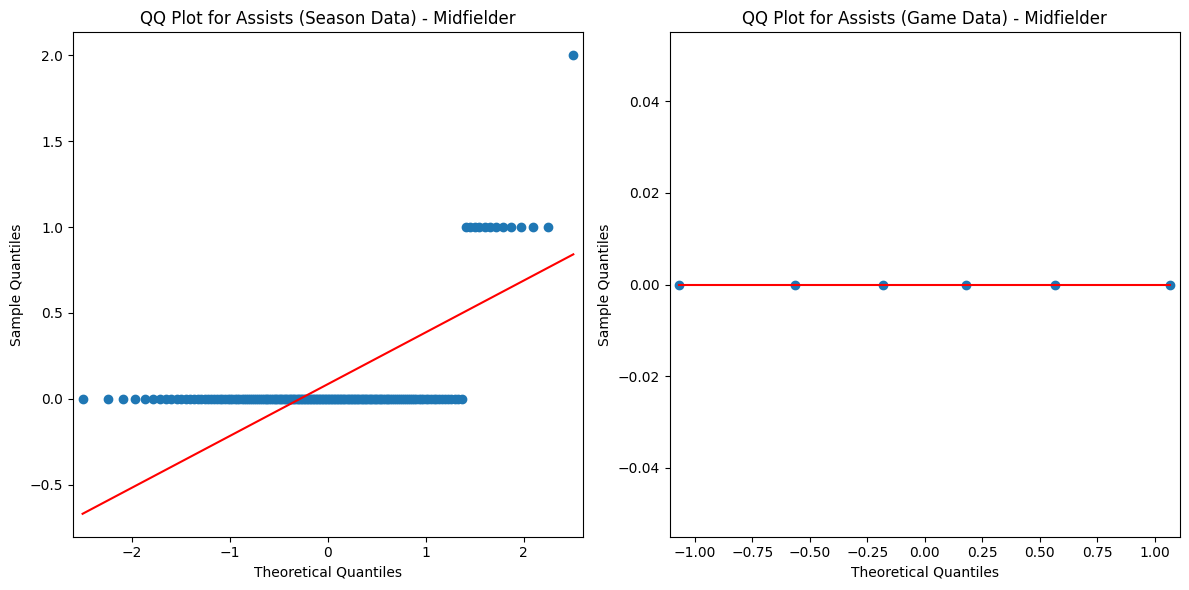

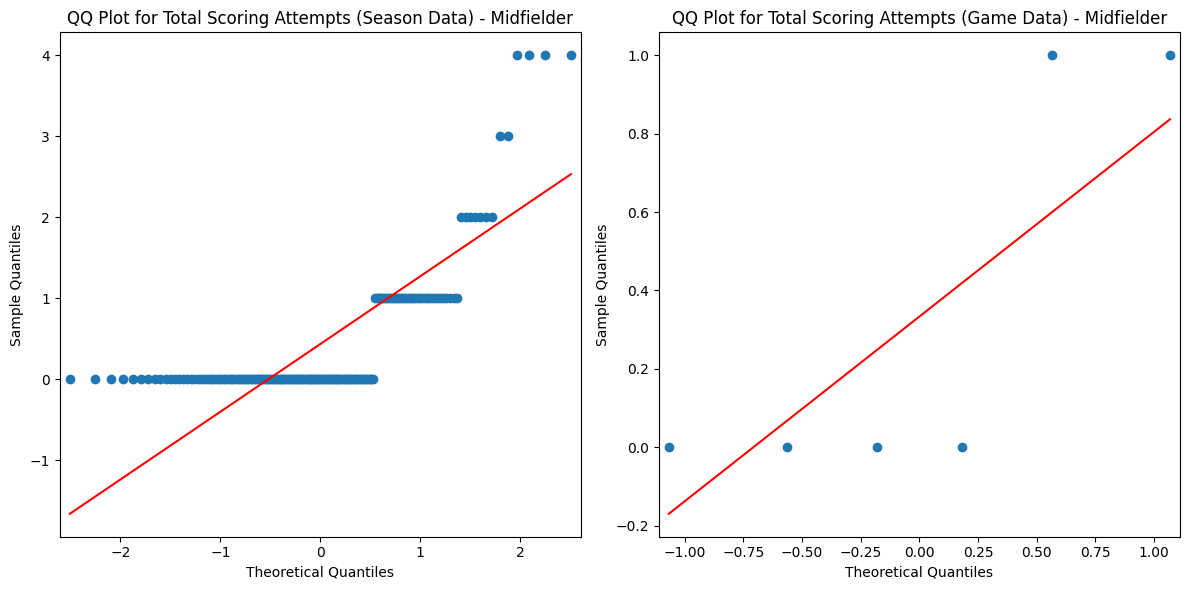

Results saved to Player_Role_Analysis.xlsx


In [7]:
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
from statsmodels.graphics.gofplots import qqplot
import seaborn as sns
import matplotlib.pyplot as plt

# Define role-specific columns
role_columns = {
    'Attacker': ['Total Scoring Attempts'],
    'Midfielder': ['Assists', 'Total Scoring Attempts']
}

# Initialize a list to store results
results = []

# Function to check normality and plot distributions
def check_normality(data, column):
    stat, p_value = shapiro(data[column].dropna())
    return p_value > 0.05, stat, p_value

# Perform statistics for each role and column
for role, columns in role_columns.items():
    role_data = combined_season[(combined_season['Role'] == role) & (combined_season['Team'] == 'RBNY')]
    game_role_data = combined_game[(combined_game['Role'] == role) & (combined_game['Team'] == 'RBNY')]

    for column in columns:
        # Check normality for season and game data
        season_normal, season_stat, season_p = check_normality(role_data, column)
        game_normal, game_stat, game_p = check_normality(game_role_data, column)
        
        # Create QQ plots for season and game data
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        qqplot(role_data[column].dropna(), line='s', ax=plt.gca())
        plt.title(f'QQ Plot for {column} (Season Data) - {role}')

        plt.subplot(1, 2, 2)
        qqplot(game_role_data[column].dropna(), line='s', ax=plt.gca())
        plt.title(f'QQ Plot for {column} (Game Data) - {role}')
        plt.tight_layout()
        plt.show()
        
        # Perform statistical test between season and game data
        if season_normal and game_normal:
            # Use t-test
            test_name = "T-Test"
            stat, p_value = ttest_ind(role_data[column].dropna(), game_role_data[column].dropna())
        else:
            # Use Mann-Whitney U test
            test_name = "Mann-Whitney U Test"
            stat, p_value = mannwhitneyu(role_data[column].dropna(), game_role_data[column].dropna())
        
        # Determine conclusion
        conclusion = "Significant Difference" if p_value < 0.05 else "No Significant Difference"
        
        # Append re sults to the list
        results.append({
            'Role': role,
            'Metric': column,
            'Season Normal (P-Value)': season_p,
            'Game Normal (P-Value)': game_p,
            'Test Used': test_name,
            'Test Stat': stat,
            'P-Value': p_value,
            'Conclusion': conclusion
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Export results to an Excel file
output_file = "Player_Role_Analysis.xlsx"
with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
    results_df.to_excel(writer, index=False, sheet_name='Analysis Results')
    print(f"Results saved to {output_file}")


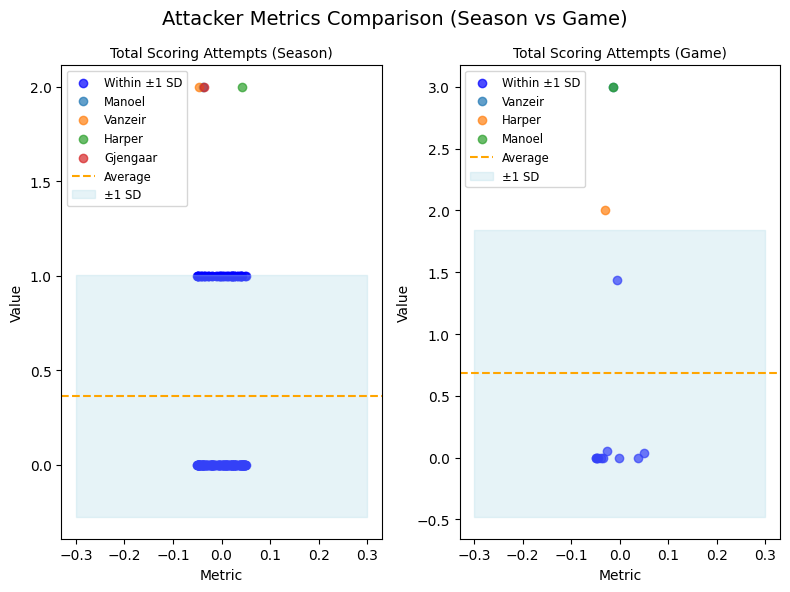

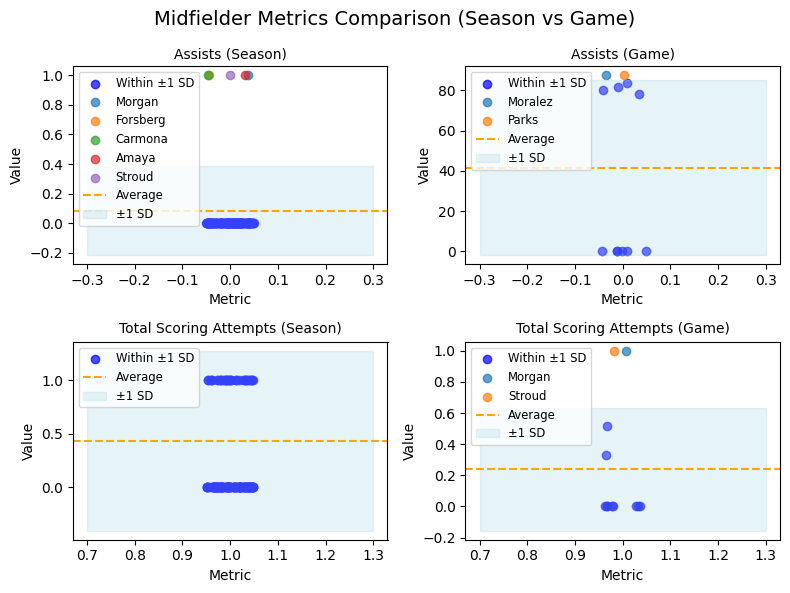

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define role-specific columns
role_columns = {
    'Attacker': ['Total Scoring Attempts'],
    'Midfielder': ['Assists', 'Total Scoring Attempts']
}

# Create plots for each role and its columns
for role, columns in role_columns.items():
    # Filter data for the current role and metrics
    role_data_season = combined_season[combined_season['Role'] == role]
    role_data_game = combined_game[combined_game['Role'] == role]
    
    # Create a figure with two subplots (one for season and one for game)
    plt.figure(figsize=(8,6))  # Adjusted the height of the figure for more compactness

    # Prepare a set for names added to the legend to avoid repetition
    added_names_season = set()
    added_names_game = set()
    jitter_strength = 0.05  # Strength of jitter (can be adjusted)

    for idx, metric in enumerate(columns):
        if metric not in role_data_season.columns or metric not in role_data_game.columns:  # Ensure the metric is present in the data
            continue

        # Prepare season data
        metric_data_season = role_data_season[metric].dropna()
        avg_value_season = metric_data_season.mean()
        std_dev_season = metric_data_season.std()
        
        # Prepare game data
        metric_data_game = role_data_game[metric].dropna()
        avg_value_game = metric_data_game.mean()
        std_dev_game = metric_data_game.std()

        # Create subplot for the season data
        plt.subplot(len(columns), 2, 2 * idx + 1)

        inside_std_season = []  # Players inside ±1 SD for season
        outside_std_season = []  # Players outside ±1 SD for season
        outside_names_season = []  # Names of players outside ±1 SD for season
        
        for i, value in enumerate(metric_data_season):
            player_name = role_data_season.iloc[i]['Last Name']  # Get player name
            if avg_value_season - std_dev_season <= value <= avg_value_season + std_dev_season:
                inside_std_season.append((idx, value))
            else:
                if player_name not in added_names_season:
                    outside_names_season.append((idx, value, player_name))
                    added_names_season.add(player_name)

        # Plot players inside ±1 SD in blue for season data
        if inside_std_season:
            inside_x_season, inside_y_season = zip(*inside_std_season)
            jittered_x_season = [x + np.random.uniform(-jitter_strength, jitter_strength) for x in inside_x_season]
            plt.scatter(
                x=jittered_x_season,
                y=inside_y_season,
                color='blue',
                label='Within ±1 SD',
                alpha=0.7
            )

        # Plot players outside ±1 SD in unique colors for season data
        for (x, y, name) in outside_names_season:
            jittered_x_season = x + np.random.uniform(-jitter_strength, jitter_strength)
            plt.scatter(
                x=[jittered_x_season],
                y=[y],
                label=name,
                alpha=0.7
            )

        # Horizontal line for the mean (season)
        plt.axhline(y=avg_value_season, color='orange', linestyle='--', label='Average')

        # Shaded area for ±1 standard deviation (season)
        plt.fill_betweenx(
            y=np.linspace(avg_value_season - std_dev_season, avg_value_season + std_dev_season, 100),
            x1=idx - 0.3,
            x2=idx + 0.3,
            color='lightblue',
            alpha=0.3,
            label='±1 SD'
        )

        plt.title(f"{metric} (Season)", fontsize=10)
        plt.xlabel('Metric')
        plt.ylabel('Value')

        # Add legend to the current subplot (for season data)
        plt.legend(loc='upper left', fontsize='small')

        # Create subplot for the game data (second plot in each row)
        plt.subplot(len(columns), 2, 2 * idx + 2)

        inside_std_game = []  # Players inside ±1 SD for game
        outside_std_game = []  # Players outside ±1 SD for game
        outside_names_game = []  # Names of players outside ±1 SD for game

        for i, value in enumerate(metric_data_game):
            player_name = role_data_game.iloc[i]['Last Name']  # Get player name
            if avg_value_game - std_dev_game <= value <= avg_value_game + std_dev_game:
                inside_std_game.append((idx, value))
            else:
                if player_name not in added_names_game:
                    outside_names_game.append((idx, value, player_name))
                    added_names_game.add(player_name)

        # Plot players inside ±1 SD in blue for game data
        if inside_std_game:
            inside_x_game, inside_y_game = zip(*inside_std_game)
            jittered_x_game = [x + np.random.uniform(-jitter_strength, jitter_strength) for x in inside_x_game]
            plt.scatter(
                x=jittered_x_game,
                y=inside_y_game,
                color='blue',
                label='Within ±1 SD',
                alpha=0.7
            )

        # Plot players outside ±1 SD in unique colors for game data
        for (x, y, name) in outside_names_game:
            jittered_x_game = x + np.random.uniform(-jitter_strength, jitter_strength)
            plt.scatter(
                x=[jittered_x_game],
                y=[y],
                label=name,
                alpha=0.7
            )

        # Horizontal line for the mean (game)
        plt.axhline(y=avg_value_game, color='orange', linestyle='--', label='Average')

        # Shaded area for ±1 standard deviation (game)
        plt.fill_betweenx(
            y=np.linspace(avg_value_game - std_dev_game, avg_value_game + std_dev_game, 100),
            x1=idx - 0.3,
            x2=idx + 0.3,
            color='lightblue',
            alpha=0.3,
            label='±1 SD'
        )

        plt.title(f"{metric} (Game)", fontsize=10)
        plt.xlabel('Metric')
        plt.ylabel('Value')

        # Add legend to the current subplot (for game data)
        plt.legend(loc='upper left', fontsize='small')

    # Adjust layout and show the plot
    plt.suptitle(f'{role} Metrics Comparison (Season vs Game)', fontsize=14)
    plt.tight_layout()
    plt.show()



In [9]:
# Import required libraries
import numpy as np

# Filter metrics with significant differences
significant_metrics = results_df[results_df['Conclusion'] == 'Significant Difference']

# Create plots for each role with significant metrics
for role, columns in role_columns.items():
    # Get significant metrics for the current role
    role_significant_metrics = significant_metrics[significant_metrics['Role'] == role]['Metric'].tolist()
    
    # Skip if no significant metrics are found
    if not role_significant_metrics:
        print(f"No significant metrics for {role}.")
        continue

    # Filter data for the current role and metrics
    role_data = combined_season[combined_season['Role'] == role]
    
    plt.figure(figsize=(12, 6))

    for idx, metric in enumerate(role_significant_metrics):
        metric_data = role_data[metric].dropna()
        avg_value = metric_data.mean()
        std_dev = metric_data.std()
        
        # Create a subplot for each metric
        plt.subplot(1, len(role_significant_metrics), idx + 1)

        # Scatter plot for individual player values
        plt.scatter(
            x=np.full_like(metric_data, idx),  # All dots align to this metric's position
            y=metric_data,
            color='blue',
            label='Player Values',
            alpha=0.7
        )

        # Horizontal line for the mean
        plt.axhline(y=avg_value, color='orange', linestyle='--', label='Average')

        # Shaded area for ±1 standard deviation
        plt.fill_betweenx(
            y=np.linspace(avg_value - std_dev, avg_value + std_dev, 100),
            x1=idx - 0.3,  # Start of shaded area (adjust width as needed)
            x2=idx + 0.3,  # End of shaded area
            color='lightblue',
            alpha=0.3,
            label='±1 SD'
        )

        # Set labels and title
        plt.title(metric, fontsize=10)
        plt.xlabel('Metric')
        plt.ylabel('Value')

    # Add a legend and layout adjustments
    plt.suptitle(f'{role} Metrics with Significant Differences', fontsize=14)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')
    plt.tight_layout()
    plt.show()


No significant metrics for Attacker.
No significant metrics for Midfielder.


In [10]:
# Import required libraries
import numpy as np

# Filter metrics with significant differences
significant_metrics = results_df[results_df['Conclusion'] == 'Significant Difference']

# Create plots for each role with significant metrics
for role, columns in role_columns.items():
    # Get significant metrics for the current role
    role_significant_metrics = significant_metrics[significant_metrics['Role'] == role]['Metric'].tolist()
    
    # Skip if no significant metrics are found
    if not role_significant_metrics:
        print(f"No significant metrics for {role}.")
        continue

    # Filter data for the current role and metrics
    role_data = combined_season[combined_season['Role'] == role]
    
    plt.figure(figsize=(12, 6))

    for idx, metric in enumerate(role_significant_metrics):
        metric_data = role_data[metric].dropna()
        avg_value = metric_data.mean()
        std_dev = metric_data.std()
        
        # Create a subplot for each metric
        plt.subplot(1, len(role_significant_metrics), idx + 1)

        # Scatter plot for individual player values
        inside_std = []  # Players inside ±1 SD
        outside_std = []  # Players outside ±1 SD
        outside_names = []  # Names of players outside ±1 SD
        
        for i, value in enumerate(metric_data):
            player_name = role_data.iloc[i]['Last Name']  # Get player name
            if avg_value - std_dev <= value <= avg_value + std_dev:
                inside_std.append((idx, value))
            else:
                outside_std.append((idx, value))
                outside_names.append(player_name)

        # Plot players inside ±1 SD in blue
        if inside_std:
            inside_x, inside_y = zip(*inside_std)
            plt.scatter(
                x=inside_x,
                y=inside_y,
                color='blue',
                label='Within ±1 SD',
                alpha=0.7
            )

        # Plot players outside ±1 SD in unique colors
        for (x, y), name in zip(outside_std, outside_names):
            plt.scatter(
                x=[x],
                y=[y],
                label=name,
                alpha=0.7
            )

        # Horizontal line for the mean
        plt.axhline(y=avg_value, color='orange', linestyle='--', label='Average')

        # Shaded area for ±1 standard deviation
        plt.fill_betweenx(
            y=np.linspace(avg_value - std_dev, avg_value + std_dev, 100),
            x1=idx - 0.3,  # Start of shaded area (adjust width as needed)
            x2=idx + 0.3,  # End of shaded area
            color='lightblue',
            alpha=0.3,
            label='±1 SD'
        )

        # Set labels and title
        plt.title(metric, fontsize=10)
        plt.xlabel('Metric')
        plt.ylabel('Value')

    # Add a legend and layout adjustments
    plt.suptitle(f'{role} Metrics with Significant Differences', fontsize=14)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')
    plt.tight_layout()
    plt.show()


No significant metrics for Attacker.
No significant metrics for Midfielder.


In [11]:
# Import required libraries
import numpy as np

# Filter metrics with significant differences
significant_metrics = results_df[results_df['Conclusion'] == 'Significant Difference']

# Create plots for each role with significant metrics
for role, columns in role_columns.items():
    # Get significant metrics for the current role
    role_significant_metrics = significant_metrics[significant_metrics['Role'] == role]['Metric'].tolist()
    
    # Skip if no significant metrics are found
    if not role_significant_metrics:
        print(f"No significant metrics for {role}.")
        continue

    # Filter data for the current role and metrics
    role_data = combined_season[combined_season['Role'] == role]
    game_role_data = combined_game[combined_game['Role'] == role]
    
    plt.figure(figsize=(12, 6))

    for idx, metric in enumerate(role_significant_metrics):
        # Extract season data for the metric
        metric_data = role_data[metric].dropna()
        avg_value = metric_data.mean()
        std_dev = metric_data.std()

        # Create a subplot for each metric
        plt.subplot(1, len(role_significant_metrics), idx + 1)

        # Scatter plot for individual player values (season data)
        inside_std = []  # Players inside ±1 SD
        outside_std = []  # Players outside ±1 SD
        outside_names = []  # Names of players outside ±1 SD

        for i, value in enumerate(metric_data):
            player_name = role_data.iloc[i]['Last Name']  # Get player name
            if avg_value - std_dev <= value <= avg_value + std_dev:
                inside_std.append((idx, value))
            else:
                outside_std.append((idx, value))
                outside_names.append(player_name)

        # Plot players inside ±1 SD in blue
        if inside_std:
            inside_x, inside_y = zip(*inside_std)
            plt.scatter(
                x=inside_x,
                y=inside_y,
                color='blue',
                label='Within ±1 SD',
                alpha=0.7
            )

        # Plot players outside ±1 SD in unique colors
        for (x, y), name in zip(outside_std, outside_names):
            plt.scatter(
                x=[x],
                y=[y],
                label=name,
                alpha=0.7
            )

        # Horizontal line for the mean
        plt.axhline(y=avg_value, color='orange', linestyle='--', label='Average')

        # Shaded area for ±1 standard deviation
        plt.fill_betweenx(
            y=np.linspace(avg_value - std_dev, avg_value + std_dev, 100),
            x1=idx - 0.3,  # Start of shaded area (adjust width as needed)
            x2=idx + 0.3,  # End of shaded area
            color='lightblue',
            alpha=0.3,
            label='±1 SD'
        )

        # Plot stars for game-specific values
        game_metric_data = game_role_data[metric].dropna()  # Get game-specific values
        for i, value in enumerate(game_metric_data):
            if avg_value - std_dev <= value <= avg_value + std_dev:  # Inside SD
                plt.scatter(
                    x=[idx],  # Keep same x position for the metric
                    y=[value],
                    color='green',
                    marker='*',  # Star marker
                    label=f"{game_role_data.iloc[i]['Last Name']} (Game)",
                    s=100,  # Larger size for stars
                    alpha=0.8
                )
            else:  # Outside SD
                plt.scatter(
                    x=[idx],
                    y=[value],
                    color='red',
                    marker='*',
                    label=f"{game_role_data.iloc[i]['Last Name']} (Game)",
                    s=100,  # Larger size for stars
                    alpha=0.8
                )

        # Set labels and title
        plt.title(metric, fontsize=10)
        plt.xlabel('Metric')
        plt.ylabel('Value')

    # Add a legend and layout adjustments
    plt.suptitle(f'{role} Metrics with Significant Differences', fontsize=14)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')
    plt.tight_layout()
    plt.show()


No significant metrics for Attacker.
No significant metrics for Midfielder.
